In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Bigger font
sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')
# Figure size®
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 2.5
rcParams['lines.marker'] = '.'
rcParams['lines.linewidth'] = 1
rcParams['lines.markersize'] = 5
rcParams['legend.fontsize'] = 10
rcParams['axes.titlesize'] = 16
# plt.rc('figure.subplot', wspace=.33)
# Slides
from notebook.services.config import ConfigManager
cm = ConfigManager()
# cm.update('livereveal', {'width': 1024, 'height': 768, 'scroll': True, 'theme': 'simple', 'transition': 'linear'});
# np.random.seed(123)
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"  # print not only the last variable
%config InlineBackend.figure_format ='retina'  # retine quality plots

## Noisy  function

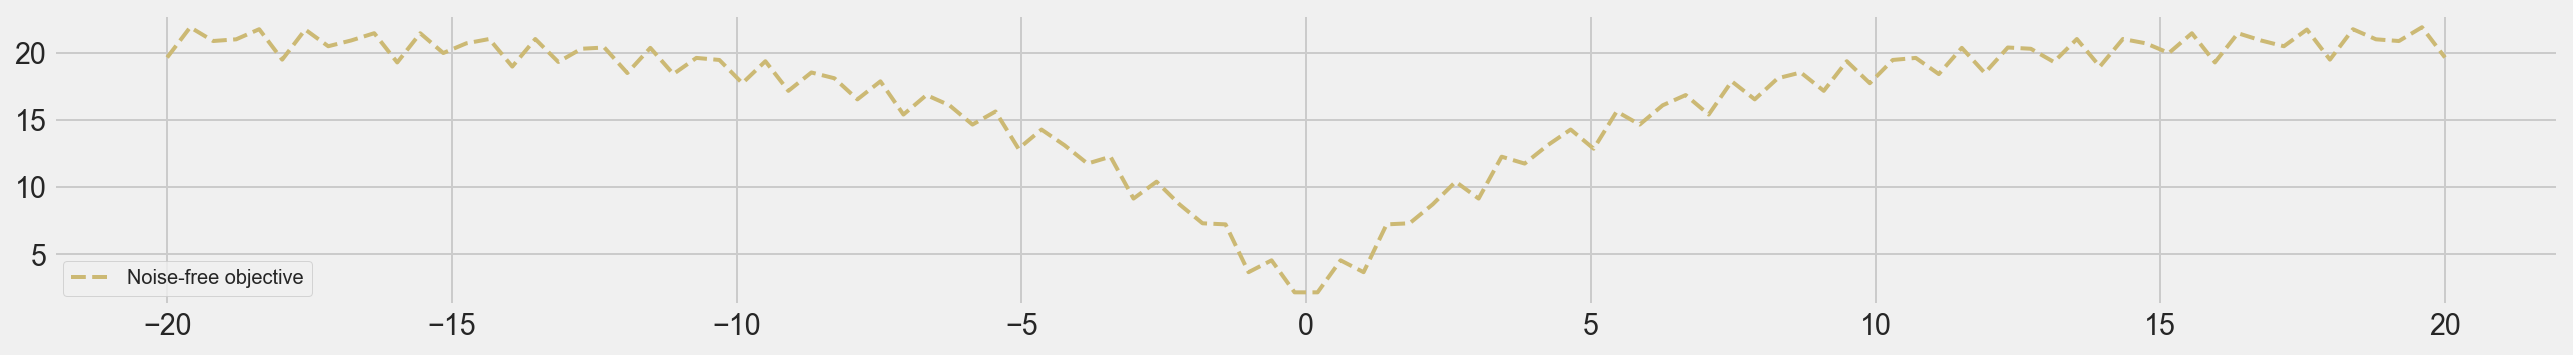

In [3]:
from evalset.test_funcs import Ackley

fun = Ackley(dim=1)
X = np.linspace(-20,20,100)
Y = np.array([fun.do_evaluate(i) for i in X])

plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.legend();

f = lambda x: fun.do_evaluate(x)

Here's a better GP implementation that should work for multiple parameters.

In [4]:
class GP:
    """
    https://github.com/matthias-wright/sarcos/blob/master/models/gaussian_processes.py
    """
    
    def __init__(self, kernel, params):
        self.X_train = None
        self.Y_train = None
        self.kernel = kernel
        self.params = params
        pass
    
    def fit(self, X_train, Y_train):
        self.X_train = X_train
        self.Y_train = Y_train
        return

    def draw_from_prior(self, X_test, num_samples):
        """
        Returns samples drawn from the prior distribution at the test inputs.
        :param num_samples: number of samples to be drawn
        :return: samples
        """
        K__star_star = GaussianProcess.RBF(X_test, X_test, self.params)
        return np.dot(K__star_star, np.random.normal(size=(len(X_test), num_samples)))

    def draw_from_posterior(self, X_test, num_samples):
        """
        Returns samples drawn from the posterior at the test inputs.
        :param num_samples: number of samples to be drawn
        :return: samples
        """
        K = GaussianProcess.RBF(self.X_train, self.X_train, self.params)
        ## Moore-Penrose) pseudo-inverse of a matrix.
        K_inverse = np.linalg.pinv(K)
#         K_inverse = np.linalg.inv(K)
        K__star_star = GaussianProcess.RBF(X_test, X_test, self.params)
        K_star_ = GaussianProcess.RBF(X_test, self.X_train, self.params)
        K__star = GaussianProcess.RBF(self.X_train, X_test, self.params)
        K_conditioned = K__star_star - np.dot(np.dot(K_star_, K_inverse), K__star)
        mu = np.dot(np.dot(K_star_, K_inverse), self.Y_train)
        return mu + np.dot(K_conditioned, np.random.normal(size=(len(X_test), num_samples)))

    def predict(self, X_test, return_std=True):
        """
        Predicts the output values for the provided inputs.
        :return: predictions, variance for the predictions
        """
        K = GP.RBF(self.X_train, self.X_train, self.params)
        ## Moore-Penrose) pseudo-inverse of a matrix.
        K_inverse = np.linalg.pinv(K)
#         K_inverse = np.linalg.inv(K)
        K__star_star = GP.RBF(X_test, X_test, self.params)
        K_star_ = GP.RBF(X_test, self.X_train, self.params)
        K__star = GP.RBF(self.X_train, X_test, self.params)
        K_conditioned = K__star_star - np.dot(np.dot(K_star_, K_inverse), K__star)
        sigma_squared = np.diag(K_conditioned)
        mu = np.dot(np.dot(K_star_, K_inverse), self.Y_train)
        
        if return_std:
            return mu, sigma_squared
        return mu

    def predict_cholesky(self, X_test, return_std=True):
        """
        Predicts the output values for the provided inputs. Uses the Cholesky decomposition (more on that in the report)
        in order to reduce computation and improve numerical stability.
        :return: predictions, variance for the predictions
        """
        K = GP.RBF(self.X_train, self.X_train, self.params)
        L = np.linalg.cholesky(K)
        K_star_ = GP.RBF(X_test, self.X_train, self.params)
        v = np.linalg.solve(L, self.Y_train)
        w = np.linalg.solve(L.T, v)
        mu = np.dot(K_star_, w)
        q = np.linalg.solve(L, K_star_.T)
        z = np.linalg.solve(L.T, q)
        K__star_star = GP.RBF(X_test, X_test, self.params)
        K_conditioned = K__star_star - np.dot(K_star_, z)
        sigma_squared = np.diag(K_conditioned)
        
        if return_std:
            return mu, sigma_squared
        return mu

    def test(self, X_test, Y_test, use_cholesky=False):
        """
        Tests the algorithm on the provided test set.
        :param use_cholesky: True: use Cholesky decomposition for computation, False: do not
        :return: RMSE for the test set, predictions on the test set, variance for the predictions
        """
        if use_cholesky:
            mu, sigma = self.predict_cholesky(X_test, self.params)
        else:
            mu, sigma = self.predict(X_test, self.params)
        rmse = np.sqrt(np.mean(np.square(mu - Y_test)))
        return rmse, mu, sigma

    @staticmethod
    def RBF(x1, x2, params): # TODO
        """
        Returns the covariance matrix according to the squared exponential kernel between x1 and x2.
        :return: Covariance matrix
        """
        dist = np.sum(x1**2, axis=1, keepdims=True) + np.sum(x2**2, axis=1) - 2 * np.dot(x1, x2.T)
        return params[0]**2 * np.exp(-(1 / (2 * params[1]**2)) * dist)
    

In [5]:
x1 = np.array([[1,2]])
x2 = np.array([[1,2]])
GP.RBF(x1, x2, params=[1,1])

array([[1.]])

In [6]:

x = np.array([[1,1], [2,2], [3,3], [5,5], [7,7], [10,10]])
y = [-0.3, 0.3, 0.5, -1.2, 0.7, -0.5]

gp = GP(GP.RBF, params=[1,1])
gp.fit(x, y)

x_new = np.array([[2,1]])
gp.predict(x_new)

(array([-0.03737244]), array([0.45274891]))

## Bayesian Optimization

In [23]:
from scipy import optimize

class BayesianOptimization:
    """ Same but simplistic GPyOpt's BayesianOptimization implementation
    """
    
    def __init__(self, f, domain, model_type, acquisition_type):
        self.f = f
        
        self.X_sample = []
        self.Y_sample = []
        self.domain = np.array([d['domain'] for d in domain])
        
        ## Surrogate Model
        if model_type is 'GP':
            # RBF Kernel
            self.model_type = GP(GP.RBF, params=[1, 0.2]) # TODO
            
        ## Acquisition Function
        if acquisition_type is 'UCB':
            def ucb(X, X_sample, Y_sample, surrogate, balance=0.8):
                mu, variance = surrogate.predict(X, return_std=True)
                return mu + balance * variance    
            def obj(X):
                # Minimization objective is the negative acquisition function
                x_new = np.array([X])
                return ucb(x_new, self.X_sample, self.Y_sample, surrogate=self.model_type)
            self.acquisition_type = obj
        pass
    
    def run_optimization(self, max_iter):
        
        initial_design_numdata = 1
        for i in range(initial_design_numdata):
            x0 = [np.random.uniform(d[0], d[1]) for d in self.domain]
            X_next = np.array([x0])
            Y_next = self.f(X_next)
            # Add sample to initial samples
            self.X_sample = np.append(self.X_sample, X_next)
            self.Y_sample = np.append(self.Y_sample, Y_next)
        print("Initialized")
        self.X_sample = np.array([self.X_sample])
        self.Y_sample = np.array([self.Y_sample])
    
        for i in range(max_iter):
            self.model_type.fit(self.X_sample, self.Y_sample)

            # Minimize and obtain next sampling point
            ### Minimize brute force
#             output = optimize.brute(self.acquisition_type, self.domain)
#             X_next = np.array([output])

            ### Minimize default
            x0 = np.array([[np.random.uniform(d[0], d[1]) for d in self.domain]])
            output = optimize.minimize(self.acquisition_type, x0=x0, bounds=self.domain).x
            X_next = np.array([output])
            
            # print(output)
            
            # Obtain next sample from the objective function
            Y_next = self.f(X_next)
            # print("x = {}, y = {}".format(X_next, Y_next))

            # Add sample to previous samples
            self.X_sample = np.concatenate((self.X_sample, X_next), axis=0)
            self.Y_sample = np.append(self.Y_sample, Y_next)
    def get_evaluations(self):
        return self.X_sample, self.Y_sample

Initialized


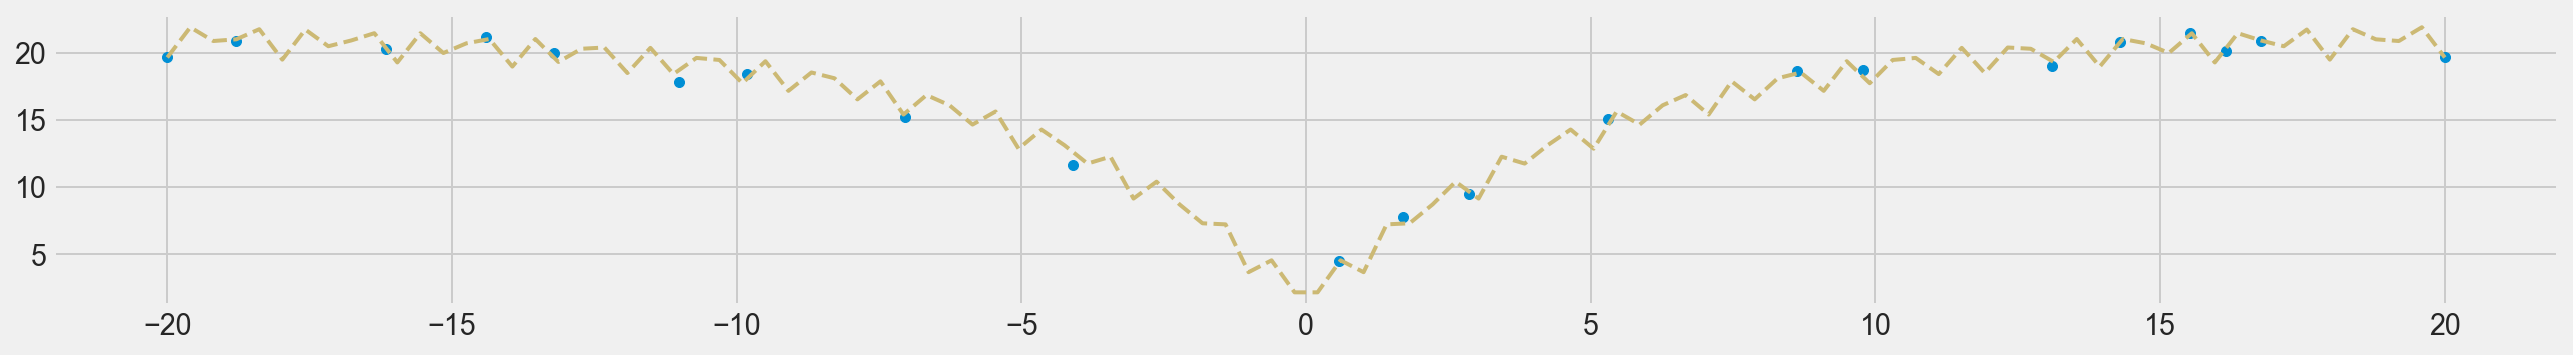

In [24]:
domain= [{'name':'x', 'type':'continuous', 'domain':(-20, 20)}]

# Finds the minimum
optimizer = BayesianOptimization(f=f, domain=domain, model_type='GP', acquisition_type ='UCB')

optimizer.run_optimization(max_iter=20)

a, b = optimizer.get_evaluations()
plt.scatter(a,b)
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')


In [25]:
a, b = optimizer.get_evaluations()
best_index = np.argmax(b)
best_x = np.reshape(a[best_index], (1, -1))
best_y = b[best_index]
print("Best parameters:", best_x, "Cum. Reward:",best_y)

Best parameters: [[15.51837829]] Cum. Reward: 21.450265811797145


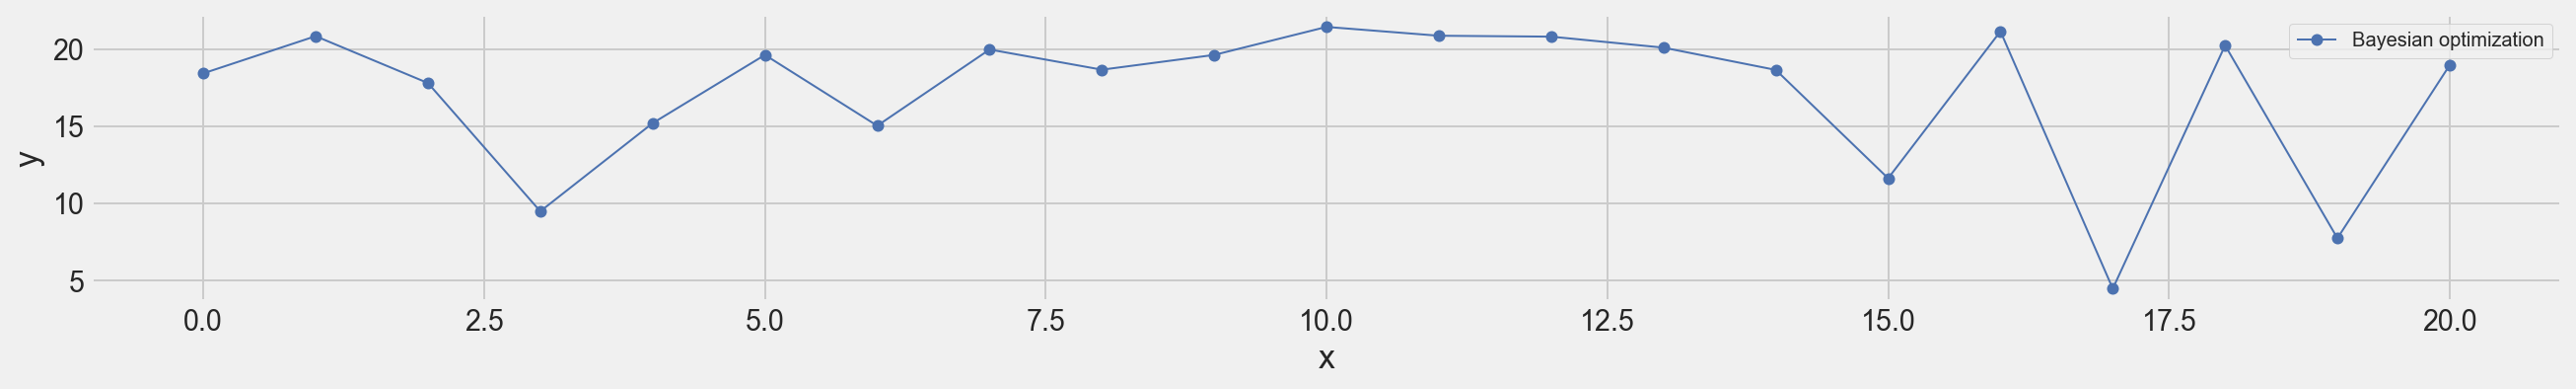

In [26]:
plt.plot(optimizer.Y_sample, 'bo-', label='Bayesian optimization');
plt.xlabel('x');
plt.ylabel('y');
# plt.title('');
plt.legend();
# f.savefig("boiterations.pdf", bbox_inches='tight');